In [1]:
# Import The Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Ignore Warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("./CSV_Files/glucose_data.csv")

In [4]:
df.head()

,reading,reading_time,Glucose_time
0,108.1092,1566846845281,2019-08-26 19:14:05
1,293.0000,1566847405038,2019-08-26 19:23:25
2,293.0000,1566847453608,2019-08-26 19:24:14
3,293.0000,1566847752466,2019-08-26 19:29:12
4,296.0000,1566848052042,2019-08-26 19:34:12


In [5]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Glucose_time'] = pd.to_datetime(df['Glucose_time'])
df.head()

,reading,reading_time,Glucose_time
0,108.1092,1566846845281,2019-08-26 19:14:05
1,293.0000,1566847405038,2019-08-26 19:23:25
2,293.0000,1566847453608,2019-08-26 19:24:14
3,293.0000,1566847752466,2019-08-26 19:29:12
4,296.0000,1566848052042,2019-08-26 19:34:12


In [6]:
data = df[["Glucose_time", "reading"]]
data.set_index('Glucose_time', inplace=True)

In [7]:
# Now we will be using 3 different methods of linear interpolation to fill the missing values in the dataset by setting the interval to 5, 10, 15 respectively

df_5 = data.resample('5min').mean().interpolate(method='linear')
df_10 = data.resample('10min').mean().interpolate(method='linear')
df_15 = data.resample('15min').mean().interpolate(method='linear')

In [8]:
df_5.head()

,reading
Glucose_time,
2019-08-26 19:10:00,108.1092
2019-08-26 19:15:00,200.5546
2019-08-26 19:20:00,293.0000
2019-08-26 19:25:00,293.0000
2019-08-26 19:30:00,296.0000


In [9]:
df_10.head()

,reading
Glucose_time,
2019-08-26 19:10:00,108.109200
2019-08-26 19:20:00,293.000000
2019-08-26 19:30:00,300.333333
2019-08-26 19:40:00,183.862488
2019-08-26 19:50:00,179.000000


In [10]:
df_15.head()

,reading
Glucose_time,
2019-08-26 19:00:00,108.109200
2019-08-26 19:15:00,293.000000
2019-08-26 19:30:00,254.317493
2019-08-26 19:45:00,180.000000
2019-08-26 20:00:00,185.919312


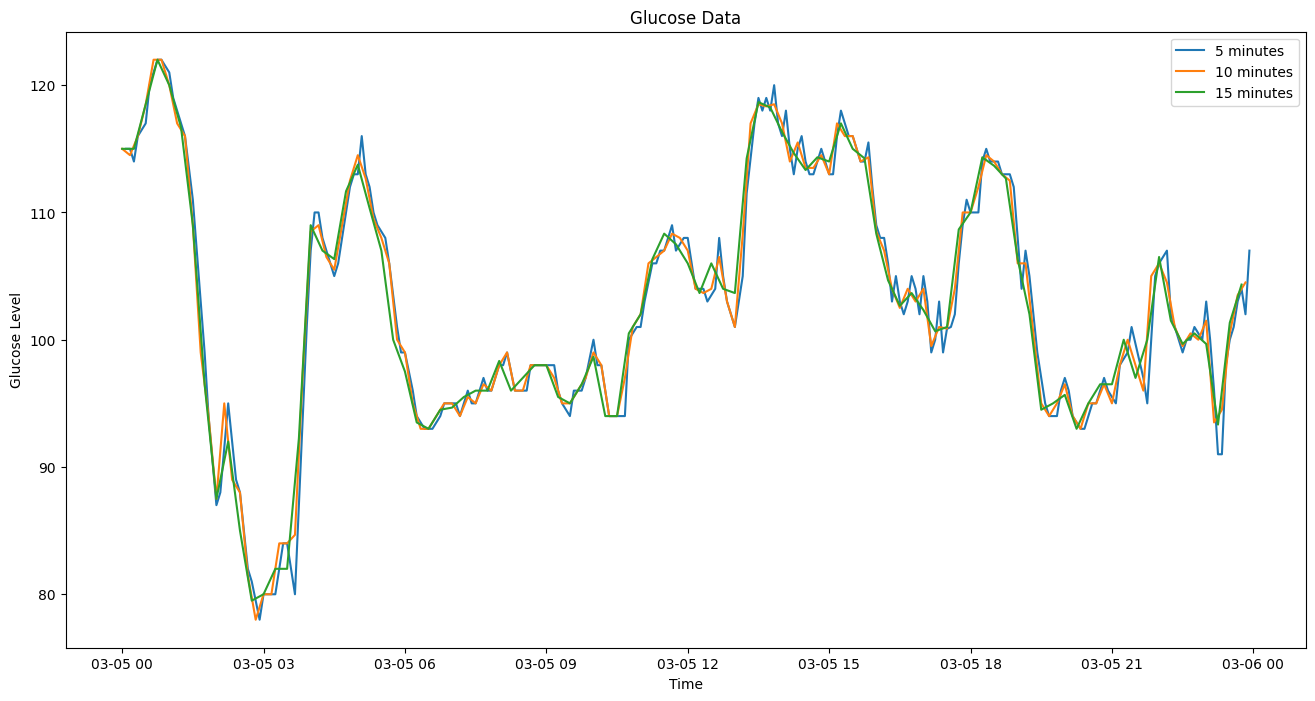

In [27]:
# Plot the Graphs of all the three datasets
plt.figure(figsize=(16, 8))
plt.plot(df_5, label='5 minutes')
plt.plot(df_10, label='10 minutes')
plt.plot(df_15, label='15 minutes')
plt.title('Glucose Data')
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.legend()

plt.show()

In [28]:
# If the Resampled_Data Folder is not present, create it
if not os.path.exists('Resampled_Data'):
    os.makedirs('Resampled_Data')

# Save the Respampled Data to the Resampled_Data Folder
df_5.to_csv('./Resampled_Data/_Resampled_5_minutes.csv')
df_10.to_csv('./Resampled_Data/_Resampled_10_minutes.csv')
df_15.to_csv('./Resampled_Data/_Resampled_15_minutes.csv')

#### <center>Plotting The ACF Plot For 5 Min Interval</center>

<Figure size 1600x800 with 0 Axes>

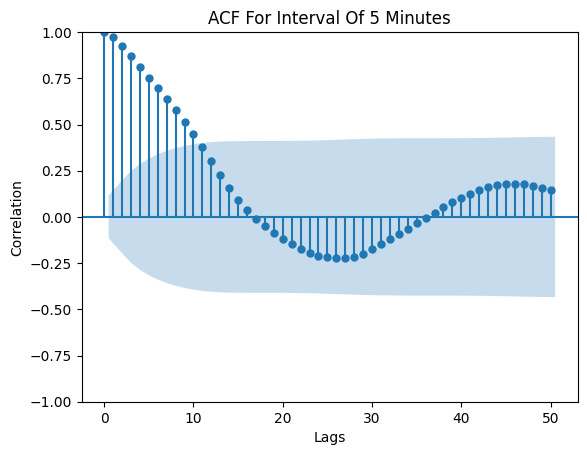

In [29]:
plt.figure(figsize=(16, 8))
plot_acf(df_5['reading'], lags=50, title='ACF 5 minutes')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('ACF For Interval Of 5 Minutes')

plt.show()


#### <center>Plotting The ACF Plot For 10 Min Interval</center>

<Figure size 1600x800 with 0 Axes>

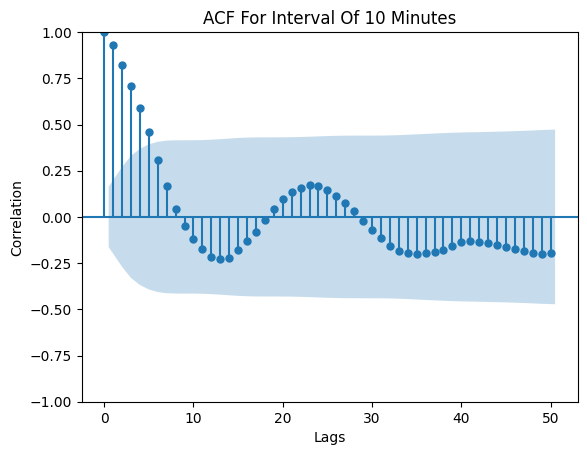

In [30]:
plt.figure(figsize=(16, 8))
plot_acf(df_10['reading'], lags=50, title='ACF Plot For 10 Min Interval')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('ACF For Interval Of 10 Minutes')

plt.show()

#### <center>Plotting The ACF Plot For 15 Min Interval</center>

<Figure size 1600x800 with 0 Axes>

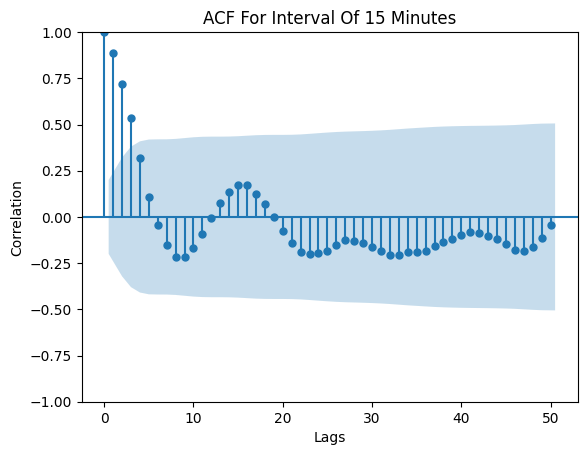

In [31]:
plt.figure(figsize=(16, 8))
plot_acf(df_15['reading'], lags=50, title='ACF Plot For 15 Min Interval')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('ACF For Interval Of 15 Minutes')

plt.show()

In [33]:
original_5 = df_5.copy()
original_10 = df_10.copy()
original_15 = df_15.copy()

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [36]:
df_5['reading'] = scaler.fit_transform(df_5[['reading']])
df_10['reading'] = scaler.fit_transform(df_10[['reading']])
df_15['reading'] = scaler.fit_transform(df_15[['reading']])

In [37]:
# Print the shape of the datasets now
print("5 min Interval ")
print(df_5.shape)

print("10 min Interval ")
print(df_10.shape)

print("15 min Interval ")
print(df_15.shape)


5 min Interval 
(287, 1)
10 min Interval 
(144, 1)
15 min Interval 
(96, 1)


In [38]:
def prepare_data(time_series_data, n_features):
    X, y = [], []
    for i in range(len(time_series_data)):
        end_ix = i + n_features
        if end_ix > len(time_series_data)-1:
            break
        seq_x, seq_y = time_series_data[i:end_ix], time_series_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [39]:
n_features_lst = [4, 5, 6, 8, 10]
patience_lst = [5, 10, 15, 20, 25]

In [40]:
time_series_5 = df_5['reading'].values
time_series_10 = df_10['reading'].values
time_series_15 = df_15['reading'].values

In [41]:
best_param_5 = {}
best_param_10 = {}
best_param_15 = {}

best_rmse_5 = float('inf')
best_rmse_10 = float('inf')
best_rmse_15 = float('inf')

best_predictions_5 = None
best_predictions_10 = None
best_predictions_15 = None

best_model_5 = None
best_model_10 = None
best_model_15 = None

#### <center>LSTM MODEL AND PREDICTIONS ON TEST DATA FOR 5 MIN INTERVAL</center>

In [44]:
for n in n_features_lst:
    for pat in patience_lst:
        X, y = prepare_data(time_series_5, n)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        test_size = 18
        train_size = X.shape[0] + (n - 5) - test_size

        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        es = EarlyStopping(monitor='val_loss', verbose=1, patience=pat)
        
        model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[es], verbose=0)

        prediction_5 = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, prediction_5))
        if rmse < best_rmse_5:
            best_rmse_5 = rmse
            best_param_5['n_features'] = n
            best_param_5['patience'] = pat
            best_predictions_5 = prediction_5
            best_model_5 = model

print('*'*50)
print("Best Parameters for 5 minutes interval", best_param_5)
print("Best RMSE for 5 minutes interval", best_rmse_5)
print('*'*50)

predictions_5_orig = scaler.inverse_transform(best_predictions_5)
predictions_5_orig.flatten()

Epoch 16: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Epoch 19: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 21: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Epoch 25: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Epoch 13: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Epoch 16: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Epoch 64: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Epoch 28: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Epoch 58: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Epoch 15: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Epoch 40: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Epoch 23: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Epoch 49: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Epoch 69: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Epoch 15: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Epoc

array([100.78081 , 100.19791 , 100.10862 , 100.54583 , 101.253044,
       101.96312 , 101.98084 , 101.326065, 102.95834 , 102.546074,
        98.22099 ,  92.89506 ,  91.67165 ,  96.57187 , 101.68358 ,
       102.931656, 103.86615 , 105.17653 , 104.01097 ], dtype=float32)

In [46]:
actual_values_5 = df_5['reading'].values[-predictions_5_orig.shape[0]:]
actual_values_5 = actual_values_5.reshape(-1, 1)
org_actual_5 = scaler.inverse_transform(actual_values_5)
org_actual_5.flatten()

array([100.75      ,  99.78409091, 100.75      , 100.75      ,
       101.71590909, 101.23295455, 100.75      , 103.64772727,
       100.75      ,  96.88636364,  92.05681818,  92.05681818,
        98.81818182, 100.75      , 101.71590909, 103.64772727,
       104.61363636, 102.68181818, 107.51136364])

In [50]:
final_df_5 = pd.DataFrame({'Actual': org_actual_5.flatten(), 'Predicted': predictions_5_orig.flatten()})

final_df_5['Glucose_time'] = df_5.index[-predictions_5_orig.shape[0]:]
final_df_5.set_index('Glucose_time', inplace=True)

final_df_5

,Actual,Predicted
Glucose_time,,
2023-03-05 22:25:00,100.750000,100.780807
2023-03-05 22:30:00,99.784091,100.197906
2023-03-05 22:35:00,100.750000,100.108620
2023-03-05 22:40:00,100.750000,100.545830
2023-03-05 22:45:00,101.715909,101.253044
2023-03-05 22:50:00,101.232955,101.963120
2023-03-05 22:55:00,100.750000,101.980843
2023-03-05 23:00:00,103.647727,101.326065
2023-03-05 23:05:00,100.750000,102.958344


#### <center>LSTM MODEL AND PREDICTIONS ON TEST DATA FOR 10 MIN INTERVAL</center>

In [57]:
for n in n_features_lst:
    for pat in patience_lst:
        X, y = prepare_data(time_series_10, n)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        test_size = 11
        train_size = X.shape[0] + (n - 5) - test_size

        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]

        print("Trains Size", X_train.shape, y_train.shape)
        print("Test Size", X_test.shape, y_test.shape)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        es = EarlyStopping(monitor='val_loss', verbose=1, patience=pat)
        
        model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[es], verbose=0)

        prediction_10 = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, prediction_10))

        if rmse < best_rmse_10:
            best_rmse_10 = rmse
            best_param_10['n_features'] = n
            best_param_10['patience'] = pat
            best_predictions_10 = prediction_10
            best_model_10 = model

print('*'*50)
print("Best Parameters for 10 minutes interval", best_param_10)
print("Best RMSE for 5 minutes interval", best_rmse_10)
print('*'*50)

predictions_10_orig = scaler.inverse_transform(best_predictions_10)
predictions_10_orig.flatten()

Trains Size (128, 4, 1) (128,)
Test Size (12, 4, 1) (12,)
Epoch 16: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Trains Size (128, 4, 1) (128,)
Test Size (12, 4, 1) (12,)
Epoch 25: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Trains Size (128, 4, 1) (128,)
Test Size (12, 4, 1) (12,)
Epoch 33: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Trains Size (128, 4, 1) (128,)
Test Size (12, 4, 1) (12,)
Epoch 31: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Trains Size (128, 4, 1) (128,)
Test Size (12, 4, 1) (12,)
Epoch 41: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Trains Size (128, 5, 1) (128,)
Test Size (11, 5, 1) (11,)
Epoch 22: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Trains Size (128, 5, 1) (128,)
Test Size (11, 5, 1) (11,)
Epoch 28: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Trains Size (128, 5, 1) (128,)
Test Size (11, 5, 1) (11,)
Epoch 31: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Trains Size (128, 5, 1) 

array([100.76771 , 100.94259 , 101.13295 , 101.50264 , 100.97031 ,
       100.51725 ,  99.49766 ,  98.919525,  99.01278 ,  99.2615  ],
      dtype=float32)

In [58]:
actual_values_10 = df_10['reading'].values[-predictions_10_orig.shape[0]:]
actual_values_10 = actual_values_10.reshape(-1, 1)
org_actual_10 = scaler.inverse_transform(actual_values_10)
org_actual_10.flatten()

array([101.71590909, 100.26704545, 101.23295455, 100.75      ,
       102.19886364,  94.47159091,  95.4375    , 101.23295455,
       104.13068182, 105.09659091])

In [59]:
final_df_10 = pd.DataFrame({'Actual': org_actual_10.flatten(), 'Predicted': predictions_10_orig.flatten()})

final_df_10['Glucose_time'] = df_10.index[-predictions_10_orig.shape[0]:]
final_df_10.set_index('Glucose_time', inplace=True)

final_df_10

,Actual,Predicted
Glucose_time,,
2023-03-05 22:20:00,101.715909,100.767708
2023-03-05 22:30:00,100.267045,100.942589
2023-03-05 22:40:00,101.232955,101.132950
2023-03-05 22:50:00,100.750000,101.502640
2023-03-05 23:00:00,102.198864,100.970306
2023-03-05 23:10:00,94.471591,100.517250
2023-03-05 23:20:00,95.437500,99.497658
2023-03-05 23:30:00,101.232955,98.919525
2023-03-05 23:40:00,104.130682,99.012779


#### <center>LSTM MODEL AND PREDICTIONS ON TEST DATA FOR 15 MIN INTERVAL</center>

In [60]:
for n in n_features_lst:
    for pat in patience_lst:
        X, y = prepare_data(time_series_15, n)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        test_size = 7
        train_size = X.shape[0] + (n - 5) - test_size

        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]

        print("Trains Size", X_train.shape, y_train.shape)
        print("Test Size", X_test.shape, y_test.shape)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        es = EarlyStopping(monitor='val_loss', verbose=1, patience=pat)
        
        model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), callbacks=[es], verbose=0)

        prediction_15 = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, prediction_15))

        if rmse < best_rmse_15:
            best_rmse_10 = rmse
            best_param_15['n_features'] = n
            best_param_15['patience'] = pat
            best_predictions_15 = prediction_15
            best_model_15 = model

print('*'*50)
print("Best Parameters for 15 minutes interval", best_param_15)
print("Best RMSE for 15 minutes interval", best_rmse_15)
print('*'*50)

predictions_15_orig = scaler.inverse_transform(best_predictions_15)
predictions_15_orig.flatten()

Trains Size (84, 4, 1) (84,)
Test Size (8, 4, 1) (8,)
Epoch 19: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
Trains Size (84, 4, 1) (84,)
Test Size (8, 4, 1) (8,)
Epoch 40: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Trains Size (84, 4, 1) (84,)
Test Size (8, 4, 1) (8,)
Epoch 33: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Trains Size (84, 4, 1) (84,)
Test Size (8, 4, 1) (8,)
Epoch 42: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Trains Size (84, 4, 1) (84,)
Test Size (8, 4, 1) (8,)
Epoch 46: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Trains Size (84, 5, 1) (84,)
Test Size (7, 5, 1) (7,)
Epoch 19: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Trains Size (84, 5, 1) (84,)
Test Size (7, 5, 1) (7,)
Epoch 37: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Trains Size (84, 5, 1) (84,)
Test Size (7, 5, 1) (7,)
Epoch 38: early stopping
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Trains Size (84, 5, 1) (84,)
Test Size (7, 5, 1) (7,)
Ep

array([100.376144, 100.67583 ], dtype=float32)

In [61]:
actual_values_15 = df_15['reading'].values[-predictions_15_orig.shape[0]:]
actual_values_15 = actual_values_15.reshape(-1, 1)
org_actual_15 = scaler.inverse_transform(actual_values_15)
org_actual_15.flatten()

array([101.33333333, 104.33333333])

In [63]:
final_df_15 = pd.DataFrame({'Actual': org_actual_15.flatten(), 'Predicted': predictions_15_orig.flatten()})

final_df_15['Glucose_time'] = df_15.index[-predictions_15_orig.shape[0]:]
final_df_15.set_index('Glucose_time', inplace=True)

final_df_15

,Actual,Predicted
Glucose_time,,
2023-03-05 23:30:00,101.333333,100.376144
2023-03-05 23:45:00,104.333333,100.675827
